# PES learning

In this example, we will use the PES learning rule
to learn a communication channel.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

import nengo
from nengo.processes import WhiteSignal
import nengo_loihi

nengo_loihi.set_defaults()

## Creating the network in Nengo

When creating a `nengo.Connection`,
you can specify a `learning_rule_type`.
When using the `nengo.PES` learning rule type,
the connection is modified such that
it can accept input in its `learning_rule` attribute.
That input is interpreted as an error signal
that the PES rule attempts to minimize over time
by adjusting decoders or connection weights.

In [2]:
with nengo.Network(label="PES learning") as model:
    # Randomly varying input signal
    stim = nengo.Node(WhiteSignal(60, high=5), size_out=1)

    # Connect pre to the input signal
    pre = nengo.Ensemble(100, dimensions=1)
    nengo.Connection(stim, pre)
    post = nengo.Ensemble(100, dimensions=1)

    # When connecting pre to post,
    # create the connection such that initially it will
    # always output 0. Usually this results in connection
    # weights that are also all 0.
    conn = nengo.Connection(
        pre,
        post,
        function=lambda x: [0],
        learning_rule_type=nengo.PES(learning_rate=2e-4),
    )

    # Calculate the error signal with another ensemble
    error = nengo.Ensemble(100, dimensions=1)

    # Error = actual - target = post - pre
    nengo.Connection(post, error)
    nengo.Connection(pre, error, transform=-1)

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

    stim_p = nengo.Probe(stim)
    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)
    error_p = nengo.Probe(error, synapse=0.01)

## Running the network in Nengo

We can use Nengo to see the desired model output.

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(10)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

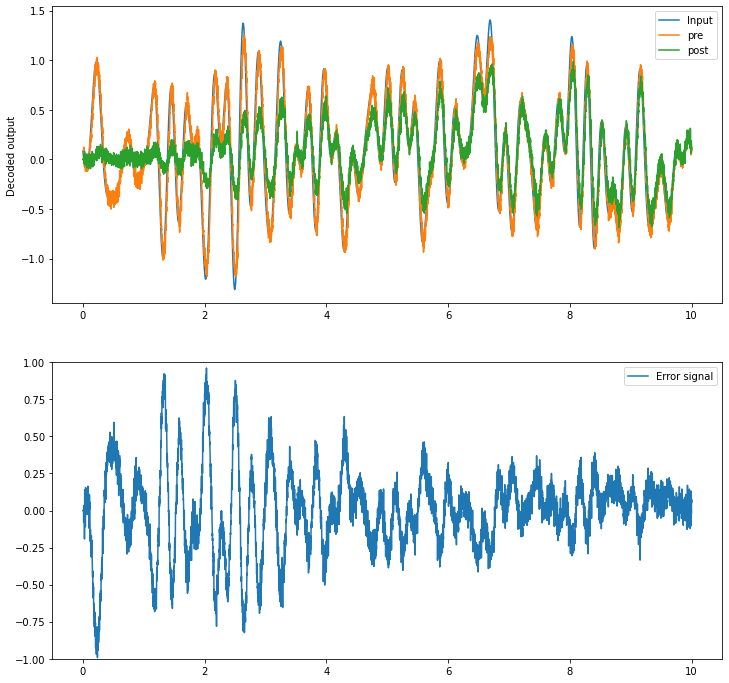

In [4]:
def plot_decoded(t, data):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(t, data[stim_p].T[0], label="Input")
    plt.plot(t, data[pre_p].T[0], label="pre")
    plt.plot(t, data[post_p].T[0], label="post")
    plt.ylabel("Decoded output")
    plt.legend(loc="best")
    plt.subplot(2, 1, 2)
    plt.plot(t, data[error_p])
    plt.ylim(-1, 1)
    plt.legend(("Error signal",), loc="best")


plot_decoded(t, sim.data)

While `post` initially only represents 0,
over time it comes to more closely track the value
represented in `pre`.
The error signal also decreases gradually over time
as the decoded values in `pre` and `post` get closer and closer.

## Running the network with NengoLoihi

In [5]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(10)
t = sim.trange()

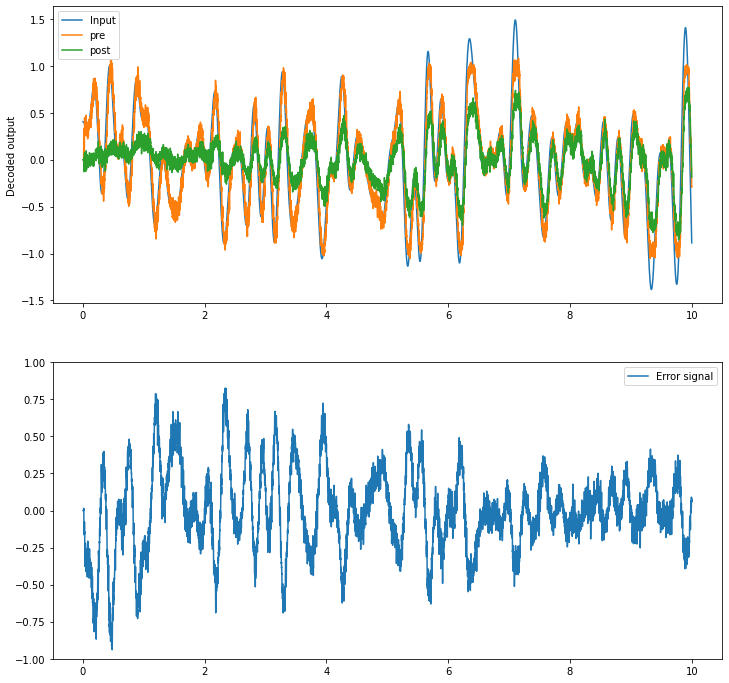

In [6]:
plot_decoded(t, sim.data)